### Environment set-up and data input

**Import libraries**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
plt.rcParams["figure.figsize"] = (10,8)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

**Load data file**


In [ ]:
df = pd.read_csv("./data/telecom-churn_dummies.csv")

In [ ]:
df.drop(labels = "Unnamed: 0", axis=1, inplace=True)

**Plotting the correlation for reference**

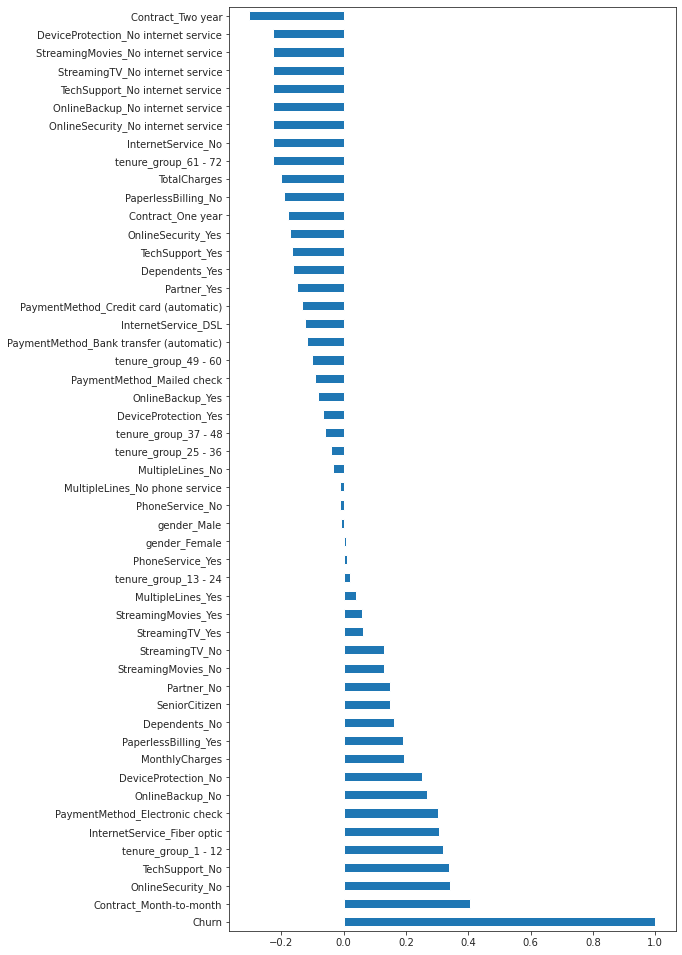

In [ ]:
plt.figure(figsize=(8,17))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='barh')

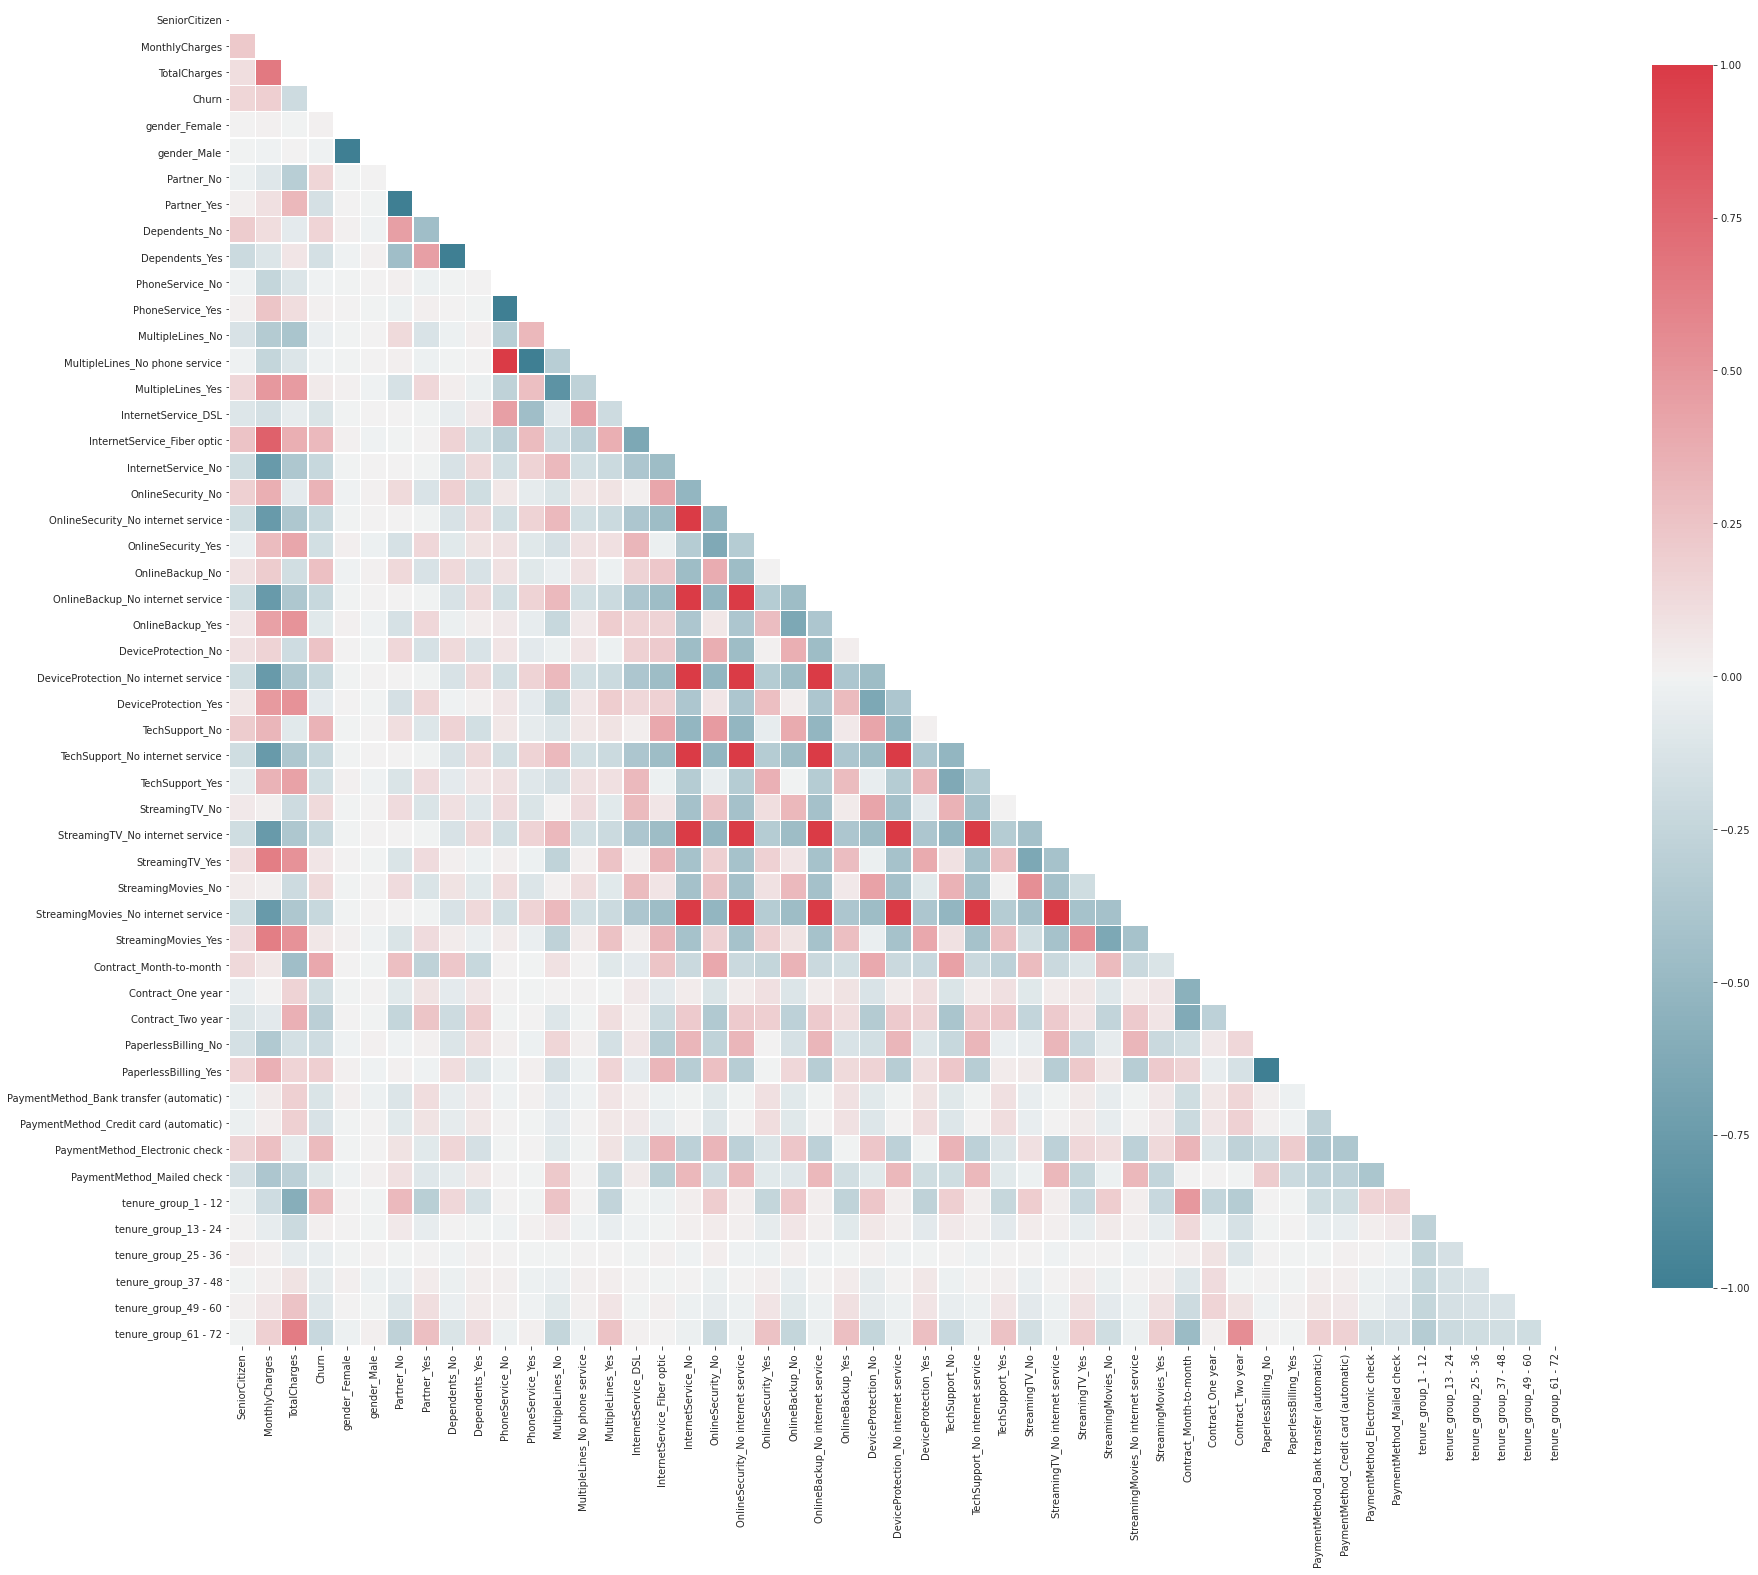

In [ ]:
# resize the figure size
plt.figure(figsize=(30,30))

# calculate the correlations
correlations = df.corr()

# create mask show no duplicate
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

# color
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlations, 
            cmap = cmap, 
            vmax = 1.0, 
            mask = mask, # no duplicate
            square = True, 
            linewidths = 0.5, 
            # annot = True, # data
            cbar_kws = {"shrink": .75}) # bar size
    
plt.show()

### Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = df.copy()

In [ ]:
MMs = MinMaxScaler()
data["MonthlyCharges"] = MMs.fit_transform(data[["MonthlyCharges"]])

### Define X and y

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data.drop(['Churn'], axis=1)
y = data["Churn"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=data["Churn"])

### Imbalance Dataset

Since we only have around 2,000 data of Churn == Yes, if we downsample the dataset, we will only remains 4,000 rows of data, therefore we will go for up-sample here.

In [ ]:
from imblearn.combine import SMOTEENN

In [ ]:
sm = SMOTEENN()
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

### Model Building - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import *

In [ ]:
base_rf = RandomForestClassifier(n_estimators=200, random_state = 100)
base_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = base_rf.predict(X_test)

In [ ]:
print(f"Model base score: {base_rf.score(X_test, y_test):.4}\n")
print(f"Model base ROC_AUC score: {roc_auc_score(y_test,y_pred):.4}\n")
print(classification_report(y_test, y_pred, labels=[0,1]))

Model base score: 0.7392

Model base ROC_AUC score: 0.7516

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



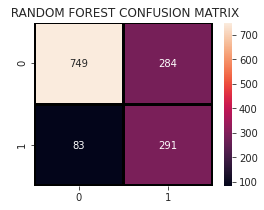

In [ ]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=2)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX")
plt.show()

#### Select Features - Random Forest Classifier

In [ ]:
feature_select = RandomForestClassifier()      
feature_select = feature_select.fit(X_train_resampled, y_train_resampled)
importances = feature_select.feature_importances_

feature_importance = zip(X_train.columns, importances)
feature_importance_df = pd.DataFrame(feature_importance, columns =['Features', 'Importances'])
feature_importance_df.sort_values(by="Importances",inplace=True,ascending=False)

# std = np.std([tree.feature_importances_ for tree in feature_select.estimators_],axis=0)
# indices = np.argsort(importances)[::-1]


# Print the feature ranking
# print("Feature ranking:")
# for f in range(X_train.shape[1]):
#     print(f"{f + 1}. feature {indices[f]} (importances[indices{f}])")

# Plot the feature importances of the forest
# plt.figure(1, figsize=(15, 10))
# plt.title("Feature importances")
# plt.bar(range(X_train.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X.columns[indices],rotation=90)
# plt.xlim([-1, X_train.shape[1]])
# plt.show()

In [ ]:
feature_importance_df.head(15)

,Features,Importances
35,Contract_Month-to-month,0.142355
2,TotalCharges,0.091294
17,OnlineSecurity_No,0.075983
26,TechSupport_No,0.065637
20,OnlineBackup_No,0.062093
42,PaymentMethod_Electronic check,0.050493
23,DeviceProtection_No,0.047083
37,Contract_Two year,0.039631
44,tenure_group_1 - 12,0.037477
1,MonthlyCharges,0.036403


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

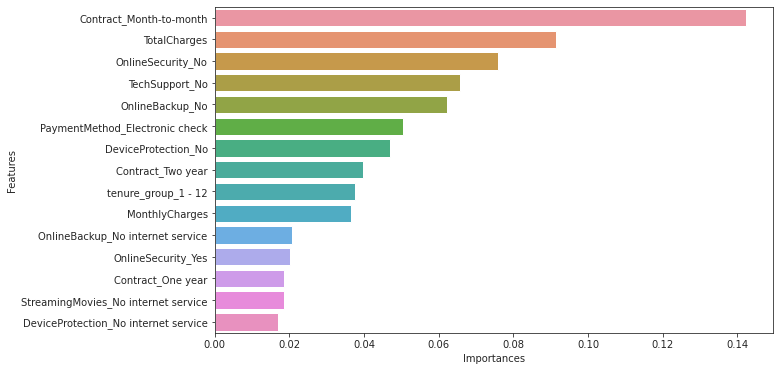

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x = "Importances", y ="Features", data = feature_importance_df.head(15))


In [ ]:
def get_feature_list(n):
  l = []
  for x in feature_importance_df.head(n).Features:
    l.append(x)

  return l

#### Select 5 features

In [ ]:
select_features_5 = get_feature_list(5)

In [ ]:
X_select5 = data[select_features_5]
y = data["Churn"]

In [ ]:
X_train_select5, X_test_select5, y_train, y_test = train_test_split(X_select5, y, test_size = 0.2, random_state=42, stratify=data["Churn"])

In [ ]:
X_train_select5_resampled, y_train_resampled = sm.fit_sample(X_train_select5,y_train)

In [ ]:
rf_select5 = RandomForestClassifier(n_estimators=200, criterion='gini', random_state = 100)
base_rf.fit(X_train_select5_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_select5 = base_rf.predict(X_test_select5)

In [ ]:
print(classification_report(y_test, y_pred_select5))
print("\nScore of test data:")
print(f" Mean Accuracy   :{base_rf.score(X_test_select5, y_test):.4}")
print(f" F1 score        :{f1_score(y_test, y_pred_select5):.4}")
print(f" Precision score :{precision_score(y_test, y_pred_select5):.4}") # label 1 score in classification report
print(f"*Recall score*   :{recall_score(y_test, y_pred_select5):.4}") # label 1 score in classification report


              precision    recall  f1-score   support

           0       0.85      0.75      0.79      1033
           1       0.47      0.62      0.54       374

    accuracy                           0.71      1407
   macro avg       0.66      0.69      0.67      1407
weighted avg       0.75      0.71      0.73      1407


Score of test data:
 Mean Accuracy   :0.715
 F1 score        :0.5375
 Precision score :0.4726
*Recall score*   :0.623


In [ ]:
# import pickle
# pkl_filename = "rf_select10.pkl"  

# with open(pkl_filename, 'wb') as f:
#     pickle.dump(rf_select10, f, pickle.HIGHEST_PROTOCOL)

#### Select 10 features

In [ ]:
select_features_10 = get_feature_list(10)

In [ ]:
X_select10 = data[select_features_10]
y = data["Churn"]

In [ ]:
X_train_select10, X_test_select10, y_train, y_test = train_test_split(X_select10, y, test_size = 0.2, random_state=42, stratify=data["Churn"])

In [ ]:
X_train_select10_resampled, y_train_resampled = sm.fit_sample(X_train_select10, y_train)

In [ ]:
rf_select10 = RandomForestClassifier(n_estimators=200, random_state = 100)
base_rf.fit(X_train_select10_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_select10 = base_rf.predict(X_test_select10)

In [ ]:
print(classification_report(y_test, y_pred_select10))
print("\nScore of test data:")
print(f" Mean Accuracy   :{base_rf.score(X_test_select10, y_test):.4}")
print(f" F1 score        :{f1_score(y_test, y_pred_select10):.4}")
print(f" Precision score :{precision_score(y_test, y_pred_select10):.4}") # label 1 score in classification report
print(f"*Recall score*   :{recall_score(y_test, y_pred_select10):.4}") # label 1 score in classification report


              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.68      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.78      0.74      0.75      1407


Score of test data:
 Mean Accuracy   :0.7448
 F1 score        :0.5869
 Precision score :0.5152
*Recall score*   :0.6818


### Hyperparameters Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {"n_estimators": [100,150,200,250,350],
              "max_depth": [1,2], # max_leaf_nodes
              # "max_leaf_nodes": 
              "min_samples_leaf": [5,10,15], # 一个节点所需的最小样本数量。任意一个分叉点，如果左右侧都至少包含这么多的样本，那么才可以被认为是一个分叉点，调节这个值可以让模型更平稳。
              "bootstrap": [True, False]}


grid_search_forest = GridSearchCV(base_rf, 
                                  param_grid, 
                                  cv = 3, 
                                  scoring = "recall",
                                  n_jobs=-1,
                                  verbose=3)

grid_search_forest.fit(X_train_select10_resampled, y_train_resampled)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   57.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

In [ ]:
print(grid_search_forest.best_estimator_)
print(f"\nThe trained recall score: {grid_search_forest.best_score_:.4f}\n")

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

The trained recall score: 0.9462



In [ ]:
# since it is test data set
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test_select10)

print(classification_report(y_test, y_pred))
print("\nScore of test data:")
print(f" Mean Accuracy   :{base_rf.score(X_test_select10, y_test):.4}")
print(f" F1 score        :{f1_score(y_test, y_pred):.4}")
print(f" Precision score :{precision_score(y_test, y_pred):.4}") # label 1 score in classification report
print(f"*Recall score*   :{recall_score(y_test, y_pred):.4}") # label 1 score in classification report


              precision    recall  f1-score   support

           0       0.91      0.63      0.74      1033
           1       0.45      0.82      0.58       374

    accuracy                           0.68      1407
   macro avg       0.68      0.73      0.66      1407
weighted avg       0.78      0.68      0.70      1407


Score of test data:
 Mean Accuracy   :0.7448
 F1 score        :0.5784
 Precision score :0.4457
*Recall score*   :0.8235


In [ ]:
param_grid_2 = {"n_estimators": [200,225,250,300,325,350],
              "max_depth": [1,2], # max_leaf_nodes
              "min_samples_leaf": [3,5,7], # 一个节点所需的最小样本数量。任意一个分叉点，如果左右侧都至少包含这么多的样本，那么才可以被认为是一个分叉点，调节这个值可以让模型更平稳。
              "bootstrap": [True, False]}


grid_search_forest_2 = GridSearchCV(base_rf, 
                                  param_grid_2, 
                                  cv = 3, 
                                  scoring = "recall",
                                  n_jobs=-1,
                                  verbose=3)

grid_search_forest_2.fit(X_train_select10_resampled, y_train_resampled)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

In [ ]:
print(grid_search_forest_2.best_estimator_)
print(f"\nThe trained recall score: {grid_search_forest_2.best_score_:.4f}\n")

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

The trained recall score: 0.9462



In [ ]:
# since it is test data set
best_model = grid_search_forest_2.best_estimator_
y_pred = best_model.predict(X_test_select10)

print(classification_report(y_test, y_pred))
print("\nScore of test data:")
print(f" Mean Accuracy   :{base_rf.score(X_test_select10, y_test):.4}")
print(f" F1 score        :{f1_score(y_test, y_pred):.4}")
print(f" Precision score :{precision_score(y_test, y_pred):.4}") # label 1 score in classification report
print(f"*Recall score*   :{recall_score(y_test, y_pred):.4}") # label 1 score in classification report


              precision    recall  f1-score   support

           0       0.91      0.63      0.74      1033
           1       0.45      0.82      0.58       374

    accuracy                           0.68      1407
   macro avg       0.68      0.73      0.66      1407
weighted avg       0.78      0.68      0.70      1407


Score of test data:
 Mean Accuracy   :0.7448
 F1 score        :0.5784
 Precision score :0.4457
*Recall score*   :0.8235


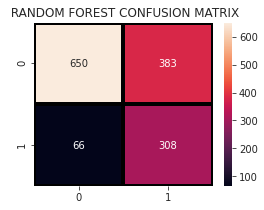

In [ ]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX")
plt.show()

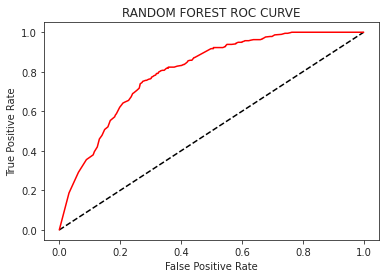

In [ ]:
y_pred_prob = best_model.predict_proba(X_test_select10)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='RANDOM FOREST',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RANDOM FOREST ROC CURVE')
plt.show();

For the final model, we would like to have a model with higher recall since it is important to not miss any customers who wanna churn, therefore we have to find out the best parameters that return a better recall rate.

### Model Building - AdaBoostClassifier　(ON-GOING)

In [ ]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
adamodel = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
adamodel.fit(X_train_select10_resampled, y_train_resampled)
y_pred_ada = adamodel.predict(X_test_select10)


In [ ]:
print(classification_report(y_test, y_pred_ada))
print("\nScore of test data:")
print(f" Mean Accuracy   :{base_rf.score(X_test_select10, y_test):.4}")
print(f" F1 score        :{f1_score(y_test, y_pred_ada):.4}")
print(f" Precision score :{precision_score(y_test, y_pred_ada):.4}") # label 1 score in classification report
print(f"*Recall score*   :{recall_score(y_test, y_pred_ada):.4}") # label 1 score in classification report


              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1033
           1       0.51      0.75      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.74      0.75      1407


Score of test data:
 Mean Accuracy   :0.7448
 F1 score        :0.6063
 Precision score :0.5081
*Recall score*   :0.7513


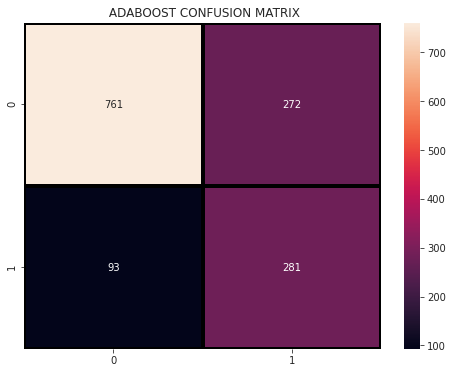

In [ ]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_ada),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" ADABOOST CONFUSION MATRIX")
plt.show()

### Save the models

In [ ]:
import pickle
pickle.dump(best_model, open('telecom_churn_best_model.sav', 'wb'))
rf = pickle.load(open('telecom_churn_best_model.sav', 'rb'))